In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
#pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , RandomizedSearchCV,KFold,RepeatedKFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder , LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import get_scorer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection  import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn import svm 
from sklearn.svm import LinearSVC
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.inspection import permutation_importance
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, RocCurveDisplay, DetCurveDisplay,PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
import math

## скажу сразу - не думаю, что нахождение аномалий применительно к нашей задачи будет эффективно
## поскольку любые машины, которые будут отличаться от "стандартных" параметров будут считаться аномалиями

In [309]:
df = pd.read_csv('train.csv')
# удалим пока строку,которая нам точно будет не нужна - это ID
df = df.drop(columns=['ID'])
df.head()

,Brand,Model,Year_of_production,Type,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box,Drive_wheels,Doors,Color,Airbags,Tax,Price
0,OPEL,Combo,2003,Goods wagon,No,Diesel,1.7,152000 km,4.0,Manual,Front,04-May,Grey,2,1438,9408
1,MERCEDES-BENZ,Vito,2008,Minivan,No,Diesel,2.2 Turbo,198700 km,4.0,Manual,Rear,02-Mar,White,6,1195,17000
2,TOYOTA,CHR,2018,Jeep,No,Petrol,2,37214 km,4.0,Automatic,Front,04-May,Grey,10,1079,36065
3,HYUNDAI,Grandeur,2012,Sedan,Yes,Petrol,3,137235 km,4.0,Automatic,Front,04-May,Silver,4,919,15524
4,MERCEDES-BENZ,ML 350,2015,Jeep,Yes,Diesel,3.5,79080 km,6.0,Automatic,4x4,04-May,Grey,12,1273,22894


In [254]:
# Функции для обработки колонок с буквами, а также для их разделения
def volume(s):
    if len(s) <= 3:
        a = s
    else:
        a = s[:3]
    return a;

def turbo(df):
    b = []
    for i in range(len(df)):
        if df['Engine_volume'][i][4:] == 'Turbo':
            b.append(1)    
        else:
            b.append(0)
    return pd.Series(b);
# Делаю новую колонку Турбо, чтобы выделять машины с турбированным двигателем
# а также разделяю пробег от километров и делаю из этого целые числа
df['Turbo'] = 0
df['Turbo'] = turbo(df)
df['Engine_volume'] = [volume(i) for i in df['Engine_volume']]
df['Engine_volume'] = df['Engine_volume'].astype(float)
df.Mileage = [int(''.join(filter(str.isdigit, i ))) for i in df.Mileage]

# Ниже буду выбрасывать выброс, которые нашел по графикам
ind = df[df['Engine_volume'] == 0].index
# это некорректные данные, поэтому удаляем их
df = df.drop(index=ind)
inde = df[df['Engine_volume'] == 20].index
df = df.drop(index=inde)
df.Mileage.nlargest(15)
# если загуглить, то можно увидеть, что можно прочитать
# Книги рекордов Гиннеса цифра – 3,2 миллиона миль (5 149 900 км) – датируется маем 2013 года.
# логично, что все пробеги ниже этого очень большого числа подходят под условия
# убираем это большьшое число(удаляем по индексу)
df = df.drop(index = 3169)
# 0 пробег у авто 2010-х годов это очень странно, что на них вообще нет пробега
ind = df[df['Mileage'] == 0].index
df = df.drop(index=ind)
#display(df[df.duplicated()])
# есть дубликаты, поэтому убираем дубликаты
#display(df[df.duplicated()].head(60))
df_duplicates = df.drop('Price', axis = 1)
dupl_rows = df_duplicates[df_duplicates.duplicated()].index
df = df.drop(index=dupl_rows)
df = df.drop_duplicates(keep = 'first')
# удаляем модель, тк эта переменная нам больше не нужна, есть бренд
df = df.drop(columns=['Model'])
display(df[df['Year_of_production'] < 1999].Price)
# Машина за почти за 50000 1995 года будет довольно сильно колебать мое обучение, поэтому считаю выбросом 
# и выбрасываю ее
df = df.drop(index=7146)
df = df[df['Year_of_production'] > 1965]


In [255]:
cat_features = ['Brand','Type','Color']
num_features = ['Year_of_production','Mileage','Tax']
columns = ['Brand','Type','Color','Fuel_type','Gear_box','Drive_wheels','Year_of_production','Mileage','Tax','Leather_interior','Doors','Engine_volume','Cylinders','Airbags','Price','Turbo']

In [297]:
fuel_type_map = [{
    'col':'Fuel_type', 
    'mapping':{'Diesel':3,'Petrol':2,'Hybrid':1,'LPG':0}
    }]
gear_box_map = [{
    'col':'Gear_box',
    'mapping':{'Tiptronic':3,'Automatic':2,'Variator':1,'Manual':0}
    }]
drive_wheels_map = [{
    'col':'Drive_wheels',
    'mapping':{'4x4':2,'Rear':1,'Front':0}
    }]
doors_map = [{
    'col':'Doors',
    'mapping':{'04-May':2,'>5':1,'02-Mar':0}
    }]
leather_interior_map = [{
    'col':'Leather_interior',
    'mapping':{'Yes':1,'No':0}
    }]

fuel_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = fuel_type_map))])

gear_box_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = gear_box_map))])

drive_wheels_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = drive_wheels_map))])

doors_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = doors_map))])

leather_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = leather_interior_map))])

   
# для деревьев можно не стандартизировать данные в фичах 
CT = ColumnTransformer(transformers=[('cat',OrdinalEncoder(),cat_features),
                                     ('fuel_type', fuel_transformer, ['Fuel_type']),
                                     ('gear_box', gear_box_transformer, ['Gear_box']),
                                     ('drive_wheels', drive_wheels_transformer, ['Drive_wheels']),
                                     ('num','passthrough',num_features), #StandardScaler
                                     ('leather',leather_transformer,['Leather_interior']),
                                     ('doors', doors_transformer, ['Doors'])],
                                      remainder = 'passthrough')

display(CT)

df_ct = CT.fit_transform(df)#.toarray()
#display(pd.DataFrame(df_ct))
df_ct = pd.DataFrame(df_ct,columns= columns)
display(df_ct)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OrdinalEncoder(),
                                 ['Brand', 'Type', 'Color']),
                                ('fuel_type',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Fuel_type',
                                                                           'mapping': {'Diesel': 3,
                                                                                       'Hybrid': 1,
                                                                                       'LPG': 0,
                                                                                       'Petrol': 2}}]))]),
                                 ['Fuel_type']),
                                ('gear_box',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Gear_box',
                                                                           'mapping': {'Auto...
                                                                                       'Rear': 1}}]))]),
                                 ['Drive_wheels']),
                                ('num', 'passthrough',
                                 ['Year_of_production', 'Mileage', 'Tax']),
                                ('leather',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Leather_interior',
                                                                           'mapping': {'No': 0,
                                                                                       'Yes': 1}}]))]),
                                 ['Leather_interior']),
                                ('doors',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Doors',
                                                                           'mapping': {'02-Mar': 0,
                                                                                       '04-May': 2,
                                                                                       '>5': 1}}]))]),
                                 ['Doors'])])

,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Price,Turbo
0,31.0,2.0,7.0,3.0,0.0,0.0,2003.0,152000.0,1438.0,0.0,2.0,1.7,4.0,2.0,9408.0,0.0
1,26.0,6.0,14.0,3.0,0.0,1.0,2008.0,198700.0,1195.0,0.0,0.0,2.2,4.0,6.0,17000.0,1.0
2,39.0,4.0,7.0,2.0,2.0,0.0,2018.0,37214.0,1079.0,0.0,2.0,2.0,4.0,10.0,36065.0,0.0
3,16.0,8.0,12.0,2.0,2.0,0.0,2012.0,137235.0,919.0,1.0,2.0,3.0,4.0,4.0,15524.0,0.0
4,26.0,4.0,7.0,3.0,2.0,2.0,2015.0,79080.0,1273.0,1.0,2.0,3.5,6.0,12.0,22894.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,13.0,8.0,12.0,1.0,3.0,0.0,2018.0,39000.0,505.0,1.0,2.0,2.0,4.0,12.0,39829.0,0.0
5894,26.0,8.0,1.0,2.0,3.0,2.0,2013.0,156800.0,1055.0,1.0,2.0,3.5,4.0,12.0,37320.0,0.0
5895,20.0,4.0,1.0,2.0,2.0,2.0,2019.0,18206.0,1275.0,1.0,2.0,2.4,4.0,12.0,18817.0,0.0
5896,16.0,8.0,1.0,2.0,3.0,0.0,2014.0,148800.0,749.0,0.0,2.0,2.4,4.0,6.0,18503.0,0.0


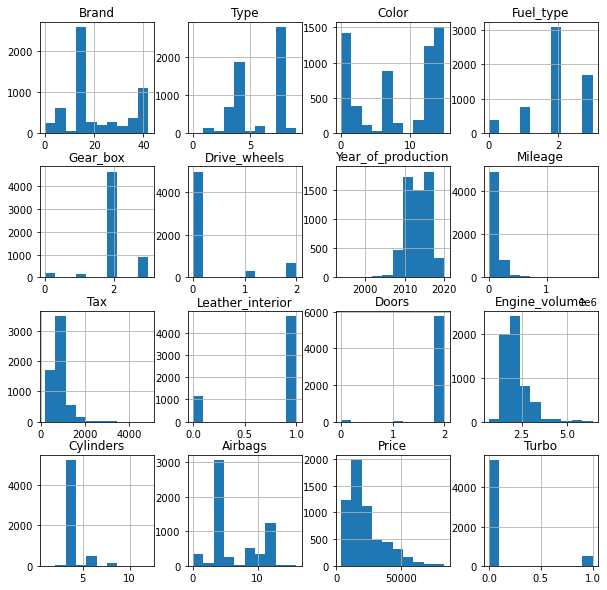

In [299]:
df_ct.hist(figsize=(10, 10));
# можно сделать преобразования пробега и налогов - перевести их к виду норм распределения
# тк данные не отрицателньые и все хорошо, можно сначала накинуть минмакс и потом Бокса-Кокса

In [302]:
# возьму преобразование Бокса-Кокса для пробег и налога
# преобраазуем переменные пробег и налог
power = PowerTransformer(method='box-cox') 
minmax = MinMaxScaler()

mile = power.fit_transform(minmax.fit_transform(pd.DataFrame(df_ct.Mileage)) + 1)
tax = power.fit_transform(minmax.fit_transform(pd.DataFrame(df_ct.Tax)) + 1)


df_ct.Mileage = mile
df_ct.Tax = tax
#преобразовываю данные и записываю в колонки моего Х после трансформера

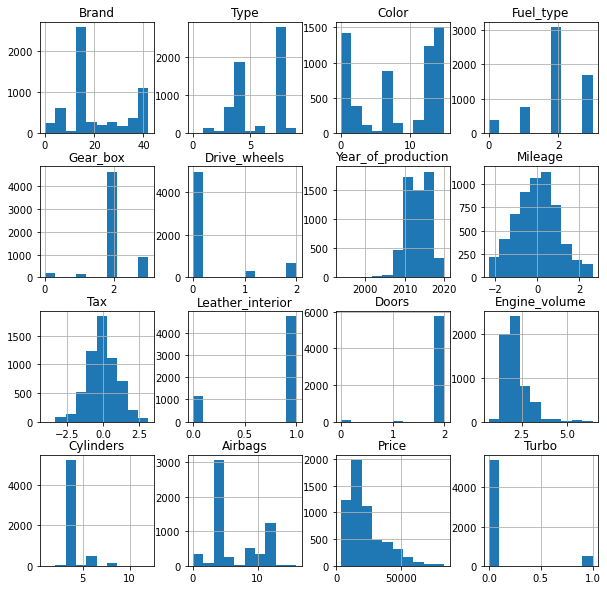

In [303]:
df_ct.hist(figsize=(10, 10));

In [ ]:
# почему выбрал Бокса-Кокса?
# При фиксированном random_state преобразования Бокса-Кокса с минмакс скалером дает лучший результа для Х
# Йео-Джонсона
#R2 0.7283640383587571
#MSE 57097448.2959105
#MAPE 0.29684660109343364

# Бокс-Кокс вместе с minmax scaler
#R2 0.7284290139762317
#MSE 57083790.52417497
#MAPE 0.2967913123229752

# Да, разница не большая, но заметная, поэтому и выбираю лучшее преобразование

In [304]:
df_features = pd.DataFrame(df_ct)
df_features.head()

,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Price,Turbo
0,31.0,2.0,7.0,3.0,0.0,0.0,2003.0,0.616573,1.740195,0.0,2.0,1.7,4.0,2.0,9408.0,0.0
1,26.0,6.0,14.0,3.0,0.0,1.0,2008.0,1.077242,1.274731,0.0,0.0,2.2,4.0,6.0,17000.0,1.0
2,39.0,4.0,7.0,2.0,2.0,0.0,2018.0,-1.291552,0.992902,0.0,2.0,2.0,4.0,10.0,36065.0,0.0
3,16.0,8.0,12.0,2.0,2.0,0.0,2012.0,0.441290,0.521859,1.0,2.0,3.0,4.0,4.0,15524.0,0.0
4,26.0,4.0,7.0,3.0,2.0,2.0,2015.0,-0.430397,1.440792,1.0,2.0,3.5,6.0,12.0,22894.0,0.0


,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Price,Turbo
Brand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,-0.106570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Color,-0.021439,0.013641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fuel_type,-0.117823,-0.259586,-0.008549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gear_box,-0.009081,0.165474,-0.078776,-0.067577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drive_wheels,0.006145,-0.163427,-0.099489,0.023687,0.137564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year_of_production,-0.030067,0.104056,-0.021094,-0.097759,0.229922,-0.042878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,0.011164,0.034284,0.045165,-0.214713,-0.107728,0.032191,-0.366242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tax,-0.047243,-0.014549,-0.050322,0.219599,-0.027327,0.330187,-0.113298,-0.016067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Leather_interior,-0.200784,0.053790,0.002117,0.119305,0.142672,-0.022422,0.161027,-0.041472,0.069206,NaN,NaN,NaN,NaN,NaN,NaN,NaN


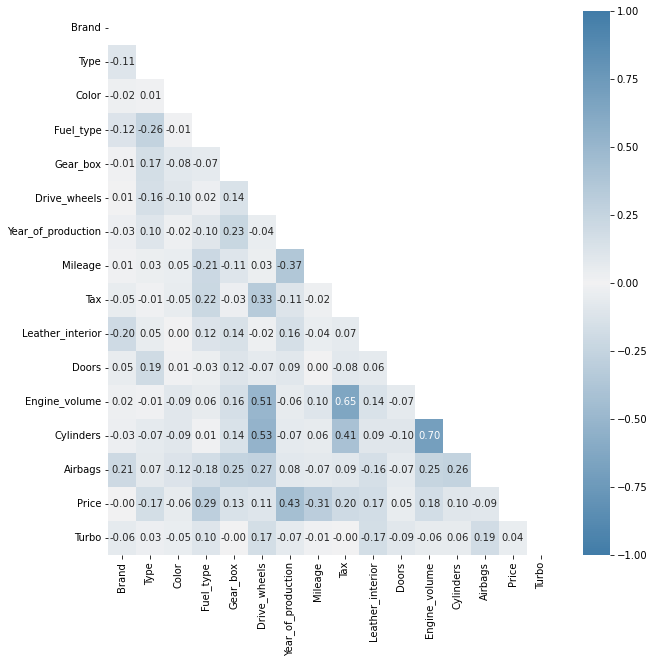

In [305]:
# как и в каждом блоке смотрим корреляцию между признаками после преобразования
plt.figure(figsize=(10,10))

corr_matrix = df_features.corr()
mask = np.tril(corr_matrix, k = -1).astype(bool)
display(corr_matrix.where(mask))

mymap = sns.diverging_palette(240, 240, as_cmap = True)

# я не использую mask как опцию в heatmap т.к. она перевернет данные :(
sns.heatmap(corr_matrix.where(mask), vmin = -1, vmax = 1,
            annot=True, fmt='.2f', center=0, cmap=mymap);
# есть пару сильно коррелируемых признаков

In [306]:
# ищет аномалии в нашем фрейме, который поступает на вход
def outlier_std(df, column, multiplier=3):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - multiplier * std
    upper_bound = mean + multiplier * std
    outliers = ~df[column].between(lower_bound,upper_bound)
    return outliers, lower_bound, upper_bound


def anomalies_detection (df, columns=None, function=outlier_std, multiplier = 3):
    if columns:
        columns_check = columns
    else:
        columns_check = df.columns
    anomalies_columns_table = {}
    anomalies = pd.Series(False, index = df.index, name='anomalies')
    for column in columns_check:
        outliers, lower_bound, upper_bound = function(df, column, multiplier = multiplier)
        anomalies[outliers[outliers].index] = True
        ### True, False для расчета процентов вычисляем среднее :)
        anomalies_columns_table[column] = [upper_bound, lower_bound, sum(outliers), 100*np.mean(outliers)]
    anomalies_columns_table = pd.DataFrame(anomalies_columns_table).T
    anomalies_columns_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_pct']
    return anomalies_columns_table, anomalies

def anomalies_report(anomalies):
    return print("Аномалий: {}\nПроцент аномалий:   {:.2f}%".format(sum(anomalies), 100*np.mean(anomalies))) 

std_data = df_features.copy()
anomalies_columns_table, anomalies = anomalies_detection(std_data, multiplier = 3)    
std_data['is_anomalies'] = anomalies

display(std_data.head())
display(anomalies_columns_table)
anomalies_report(anomalies)

,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Price,Turbo,is_anomalies
0,31.0,2.0,7.0,3.0,0.0,0.0,2003.0,0.616573,1.740195,0.0,2.0,1.7,4.0,2.0,9408.0,0.0,True
1,26.0,6.0,14.0,3.0,0.0,1.0,2008.0,1.077242,1.274731,0.0,0.0,2.2,4.0,6.0,17000.0,1.0,True
2,39.0,4.0,7.0,2.0,2.0,0.0,2018.0,-1.291552,0.992902,0.0,2.0,2.0,4.0,10.0,36065.0,0.0,False
3,16.0,8.0,12.0,2.0,2.0,0.0,2012.0,0.441290,0.521859,1.0,2.0,3.0,4.0,4.0,15524.0,0.0,False
4,26.0,4.0,7.0,3.0,2.0,2.0,2015.0,-0.430397,1.440792,1.0,2.0,3.5,6.0,12.0,22894.0,0.0,False


,upper_bound,lower_bound,anomalies_count,anomalies_pct
Brand,56.222649,-14.076159,0.0,0.000000
Type,12.646843,-0.913713,0.0,0.000000
Color,23.930241,-7.672187,0.0,0.000000
Fuel_type,4.484849,-0.421438,0.0,0.000000
Gear_box,3.742243,0.374406,201.0,3.407935
Drive_wheels,2.218069,-1.673477,0.0,0.000000
Year_of_production,2022.269096,2004.186991,49.0,0.830790
Mileage,3.000254,-3.000254,0.0,0.000000
Tax,3.000254,-3.000254,28.0,0.474737
Leather_interior,1.991214,-0.377447,0.0,0.000000


Аномалий: 877
Процент аномалий:   14.87%


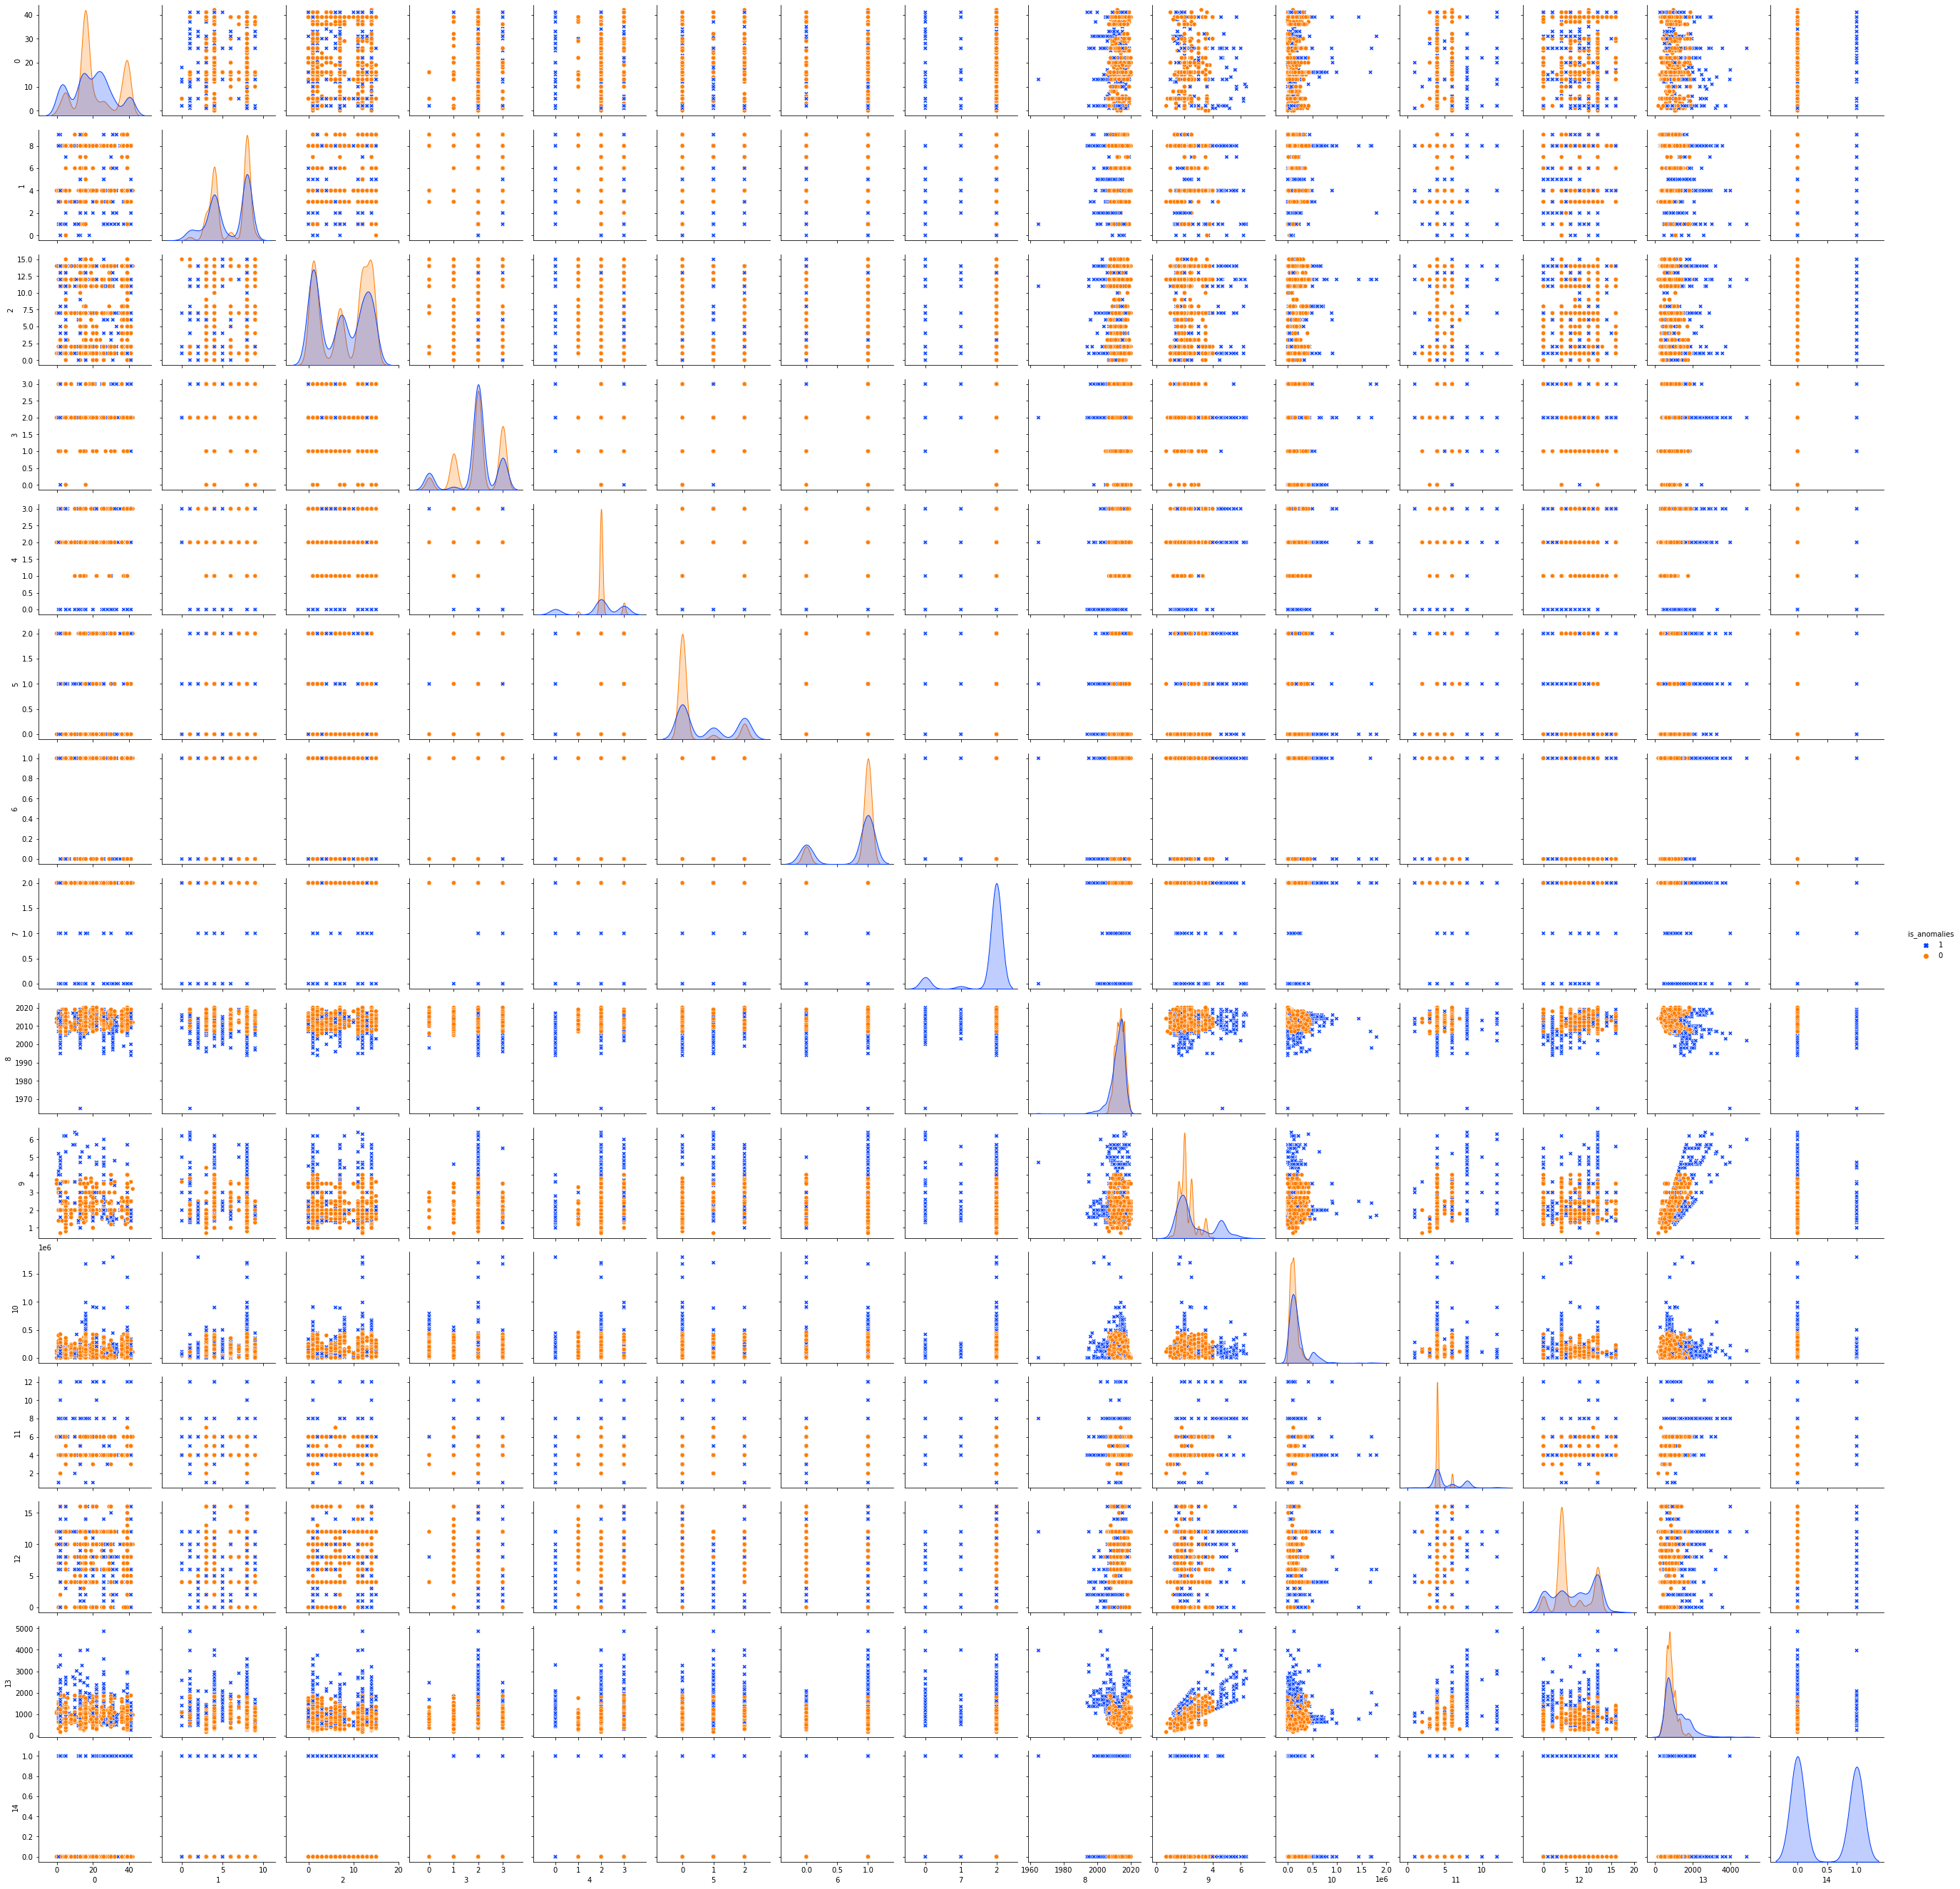

In [26]:
# на графике виды аномалии, которые отмечаются синим цветом
sns.pairplot(data = std_data, 
             hue='is_anomalies', hue_order=[1, 0], 
             diag_kind="kde",
             diag_kws=dict(common_norm=False),
             markers=['o','X'],  palette='bright');

In [307]:
# функции для отбора аномалий в заданном фрейме
class AnomaliesDistance(BaseEstimator):
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(bool)
        return predictions

In [308]:
euclidian_model = AnomaliesDistance(metric='euclidean', percentile=99)
# выбираю аномальность значения на уровне 99
euclidian_model.fit(df_features)   
euclidian_anomalies = euclidian_model.predict(df_features)   
euclidian_anomalies
anomalies_report(euclidian_anomalies)

Аномалий: 59
Процент аномалий:   1.00%


In [280]:
df_features['is_anomalies'] = euclidian_anomalies

In [239]:
ii = df_features[df_features['is_anomalies']==True].index
# индексы позиций, где стоят аномалии

In [271]:
# убираем аномалии и смотрим на результаты, тут пока все колонки, без очистки
df_cT = df_ct.copy()
df_cT = df_cT.drop(index=ii)
y = np.array(df_cT.Price)
X = df_cT.drop(columns=['Price','is_anomalies'])

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

In [273]:
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
#estimator.score(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.7223481492064047
MSE 54381076.70200563
MAPE 0.3092136602846903


In [277]:
# убираю неинформативные колонки, которые я отобрал в файле Features и также убираю аномалии
df_cT = df_ct.copy()
df_cT = df_cT.drop(index=ii)
y = np.array(df_cT.Price)
X = df_cT.drop(columns=['Price','is_anomalies','Doors','Cylinders','Leather_interior'])

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

In [279]:
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
#estimator.score(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.6862220786090865
MSE 65647705.43954644
MAPE 0.3349327595054236


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


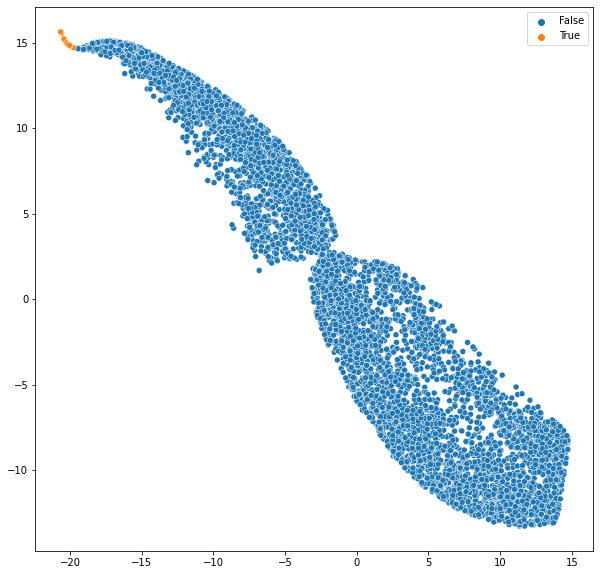

In [281]:
tsne = TSNE(perplexity = 750, n_jobs = -1)
tsne_transformed = tsne.fit_transform(df_features)

plt.figure(figsize=(10, 10))
sns.scatterplot(x = tsne_transformed[:, 0], y = tsne_transformed[:, 1], hue = euclidian_anomalies);

# Isolation Forest

In [283]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=600, 
                                   contamination=0.01, 
                                   #max_features=1, 
                                   #bootstrap=True
                                  )
isolation_forest.fit(df_features.values)

isolation_predict = isolation_forest.predict(df_features.values)
anomalies = np.where(isolation_predict < 0, True, False)
anomalies_report(anomalies)


Аномалий: 59
Процент аномалий:   1.00%


In [290]:
isolation_data = df_features.copy()
isolation_data['is_anomalies'] = anomalies
isolation_data
iii = isolation_data[isolation_data['is_anomalies']==True].index

In [292]:
# убираем аномалии и смотрим на результаты, тут пока все колонки, без очистки
df_cT = df_ct.copy()
df_cT = df_cT.drop(index=iii)
y = np.array(df_cT.Price)
X = df_cT.drop(columns=['Price','is_anomalies','Doors','Cylinders','Leather_interior'])

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [294]:
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.7175503973229087
MSE 55475220.32068885
MAPE 0.32238027362953375


#### Взяв даже несколько алгоритмов аномалий и удалив эти строки моя модель не сильно улучшила свои показатели

### Удалив даже 60 аномальных значений, я не могу сказать строго, что результат улучшился, поэтому в основм блоке я не буду убирать аномалии, поскольку аномалии это весьма субъективная модель от задачи к задачи и применительно к нашей задаче - аномалии могут быть ошибочные, поскольку данные с машинами очень сильно разнятся. Поэтому не беру аномалии в основной код, а оставляю его как дполнительный